## Importing Libraries

In [59]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt

In [40]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size =  (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [17]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)                                # batch of 32 images each of size 256x256 and having 3 channels
    print(label_batch.numpy())                              # labels of the 32 images as a numpy array

(32, 256, 256, 3)
[0 2 0 0 0 2 1 2 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 2]


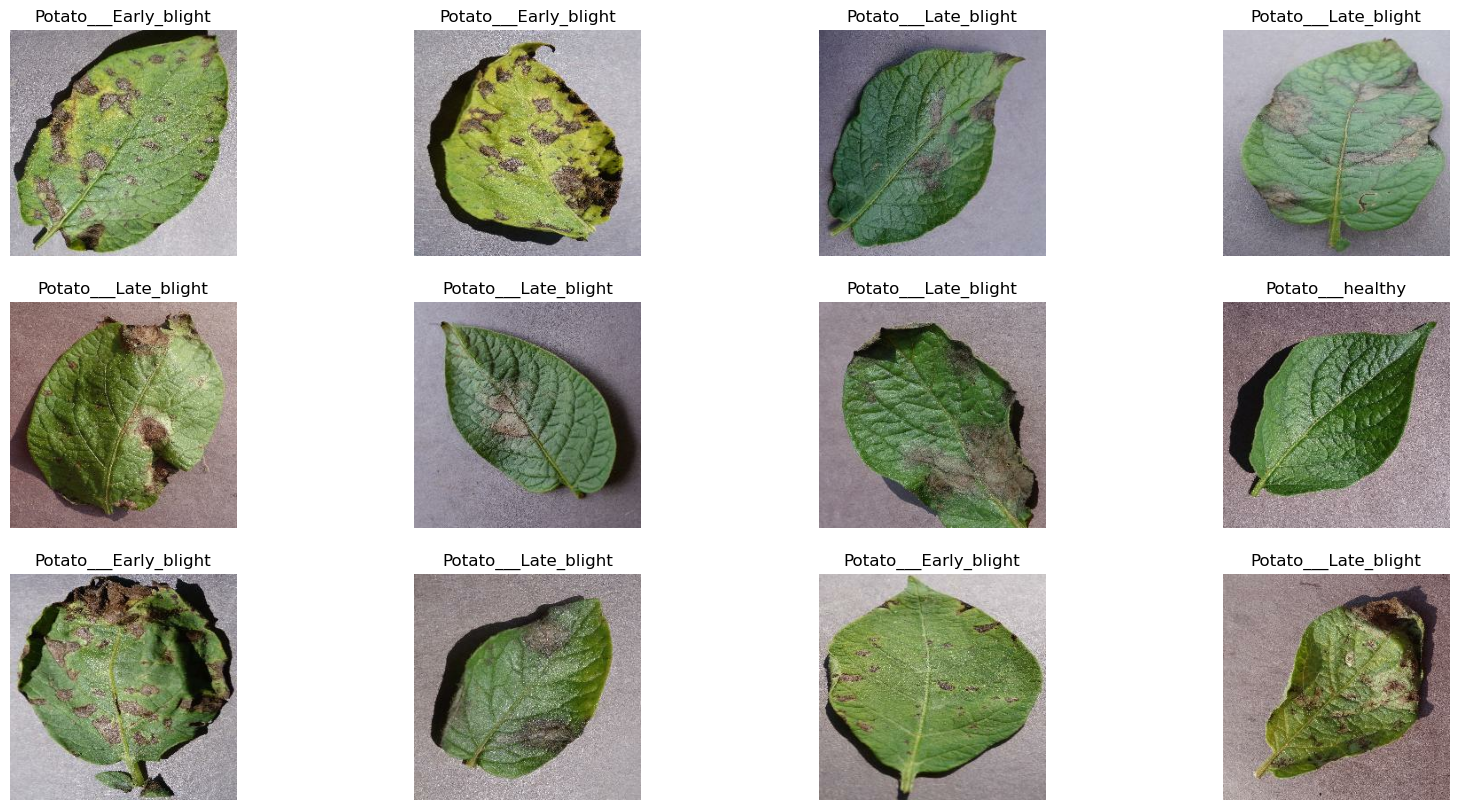

In [38]:
plt.figure(figsize = (20,10))
for image_batch, label_batch in dataset.take(1):
    
    for i in range (0,12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

### Train-Test-Split

In [39]:
len(dataset)

68

In [43]:
train_size_ratio = 0.8
validation_size_ratio = 0.1
test_size_ratio = 0.1

In [44]:
train_length = int(len(dataset)*train_size_ratio)
validation_length = int(len(dataset)*validation_size_ratio)
test_length = int(len(dataset)*test_size_ratio)

In [45]:
(train_length, validation_length, test_length)  # Here you can see that we lose 2 entire batches (54+6+6 = 66 != 68) so we cant hardcode the length of the datasets.

(54, 6, 6)

In [48]:
# Function to generate the train-validation-test-split
def get_dataset_partitions_tf(ds, train_size_ratio = 0.8, validation_size_ratio = 0.1, test_size_ratio = 0.1, shuffle = True, shuffle_size = 10000):
    
    if (shuffle):
        ds.shuffle(shuffle_size, seed = 12)
    
    ds_size = len(ds)
    train_size = int(ds_size * train_size_ratio)
    val_size = int(ds_size * validation_size_ratio)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return (train_ds, val_ds, test_ds)

In [49]:
(train_ds, val_ds, test_ds) = get_dataset_partitions_tf(dataset)

In [51]:
len(train_ds)

54

In [52]:
len(test_ds)

8

In [53]:
len(val_ds)

6

In [55]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Pre-Processing

In [66]:
resize_and_rescale = models.Sequential()
resize_and_rescale.add(layers.Resizing(IMAGE_SIZE, IMAGE_SIZE))   # Re-sizing to 256x256
resize_and_rescale.add(layers.Rescaling(scale=1.0/255))           # Re-scalng to get values between 0 and 1

### Data Augmentation

In [89]:
data_augmentation = models.Sequential()
data_augmentation.add(layers.RandomFlip("horizontal_and_vertical"))
data_augmentation.add(layers.RandomRotation(0.3))

### Making the model

In [90]:
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
N_CLASSES = 3

In [91]:
model = models.Sequential()
# Resize, Re-scale, Augment
model.add(resize_and_rescale)
model.add(data_augmentation)
# Convolution layers
model.add(layers.Conv2D(filters = 48, kernel_size = (3,3), activation = 'relu', input_shape = INPUT_SHAPE))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
# Flatten layer
model.add(layers.Flatten())
# Dense layers
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(N_CLASSES, activation = 'softmax'))

In [92]:
model.build(input_shape = INPUT_SHAPE)  # The Warnings shown below are mainly due to a bug in tf version 2.10.1 which causes random rotate and other augmentation layers to be very slow.

In [93]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   multiple                  0         
                                                                 
 sequential_10 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 254, 254, 48)      1344      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 127, 48)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 64)      27712     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [94]:
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])

In [95]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 81s 1s/step - loss: 0.9142 - accuracy: 0.4560 - val_loss: 0.8517 - val_accuracy: 0.7344
Epoch 2/50
54/54 [==============================] - 79s 1s/step - loss: 0.7520 - accuracy: 0.6476 - val_loss: 0.6151 - val_accuracy: 0.7812
Epoch 3/50
54/54 [==============================] - 84s 2s/step - loss: 0.5608 - accuracy: 0.7650 - val_loss: 0.4872 - val_accuracy: 0.8073
Epoch 4/50
54/54 [==============================] - 89s 2s/step - loss: 0.4349 - accuracy: 0.8119 - val_loss: 0.3341 - val_accuracy: 0.8490
Epoch 5/50
54/54 [==============================] - 86s 2s/step - loss: 0.3281 - accuracy: 0.8721 - val_loss: 0.3434 - val_accuracy: 0.8646
Epoch 6/50
54/54 [==============================] - 86s 2s/step - loss: 0.2863 - accuracy: 0.8814 - val_loss: 0.3237 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 87s 2s/step - loss: 0.2974 - accuracy: 0.8866 - val_loss: 0.2940 - val_accuracy: 0.8906
Epoch 8/50
54/54 [==

In [100]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 323ms/step - loss: 0.1653 - accuracy: 0.9310


In [101]:
scores

[0.1653445065021515, 0.931034505367279]

In [104]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [108]:
import numpy as np
np.mean(history.history['val_accuracy'])

0.9371874988079071

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

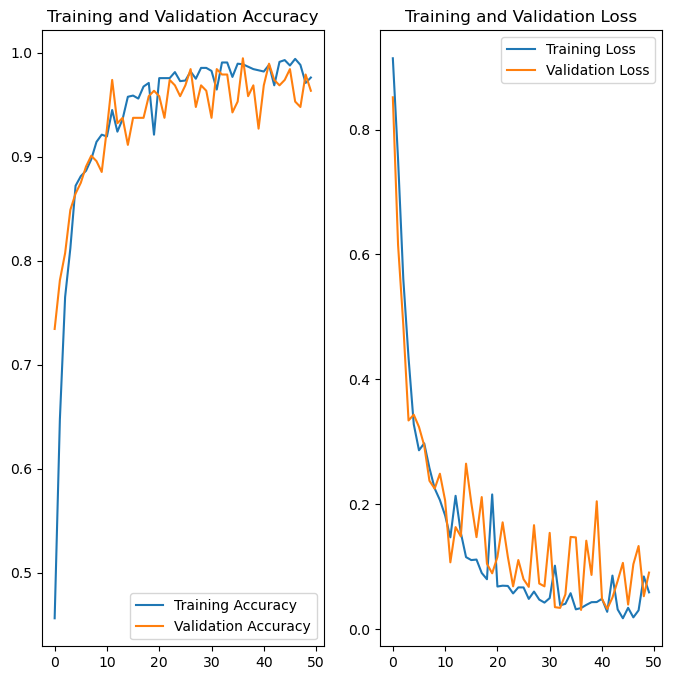

In [113]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 355ms/step
predicted label: Potato___Early_blight


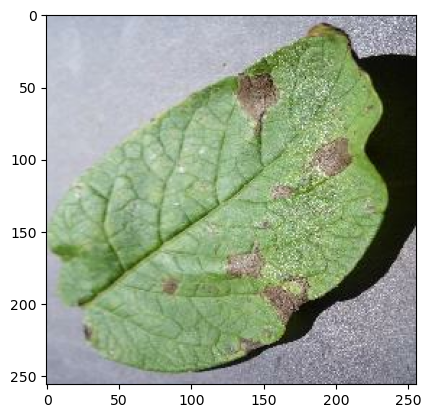

In [134]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [142]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


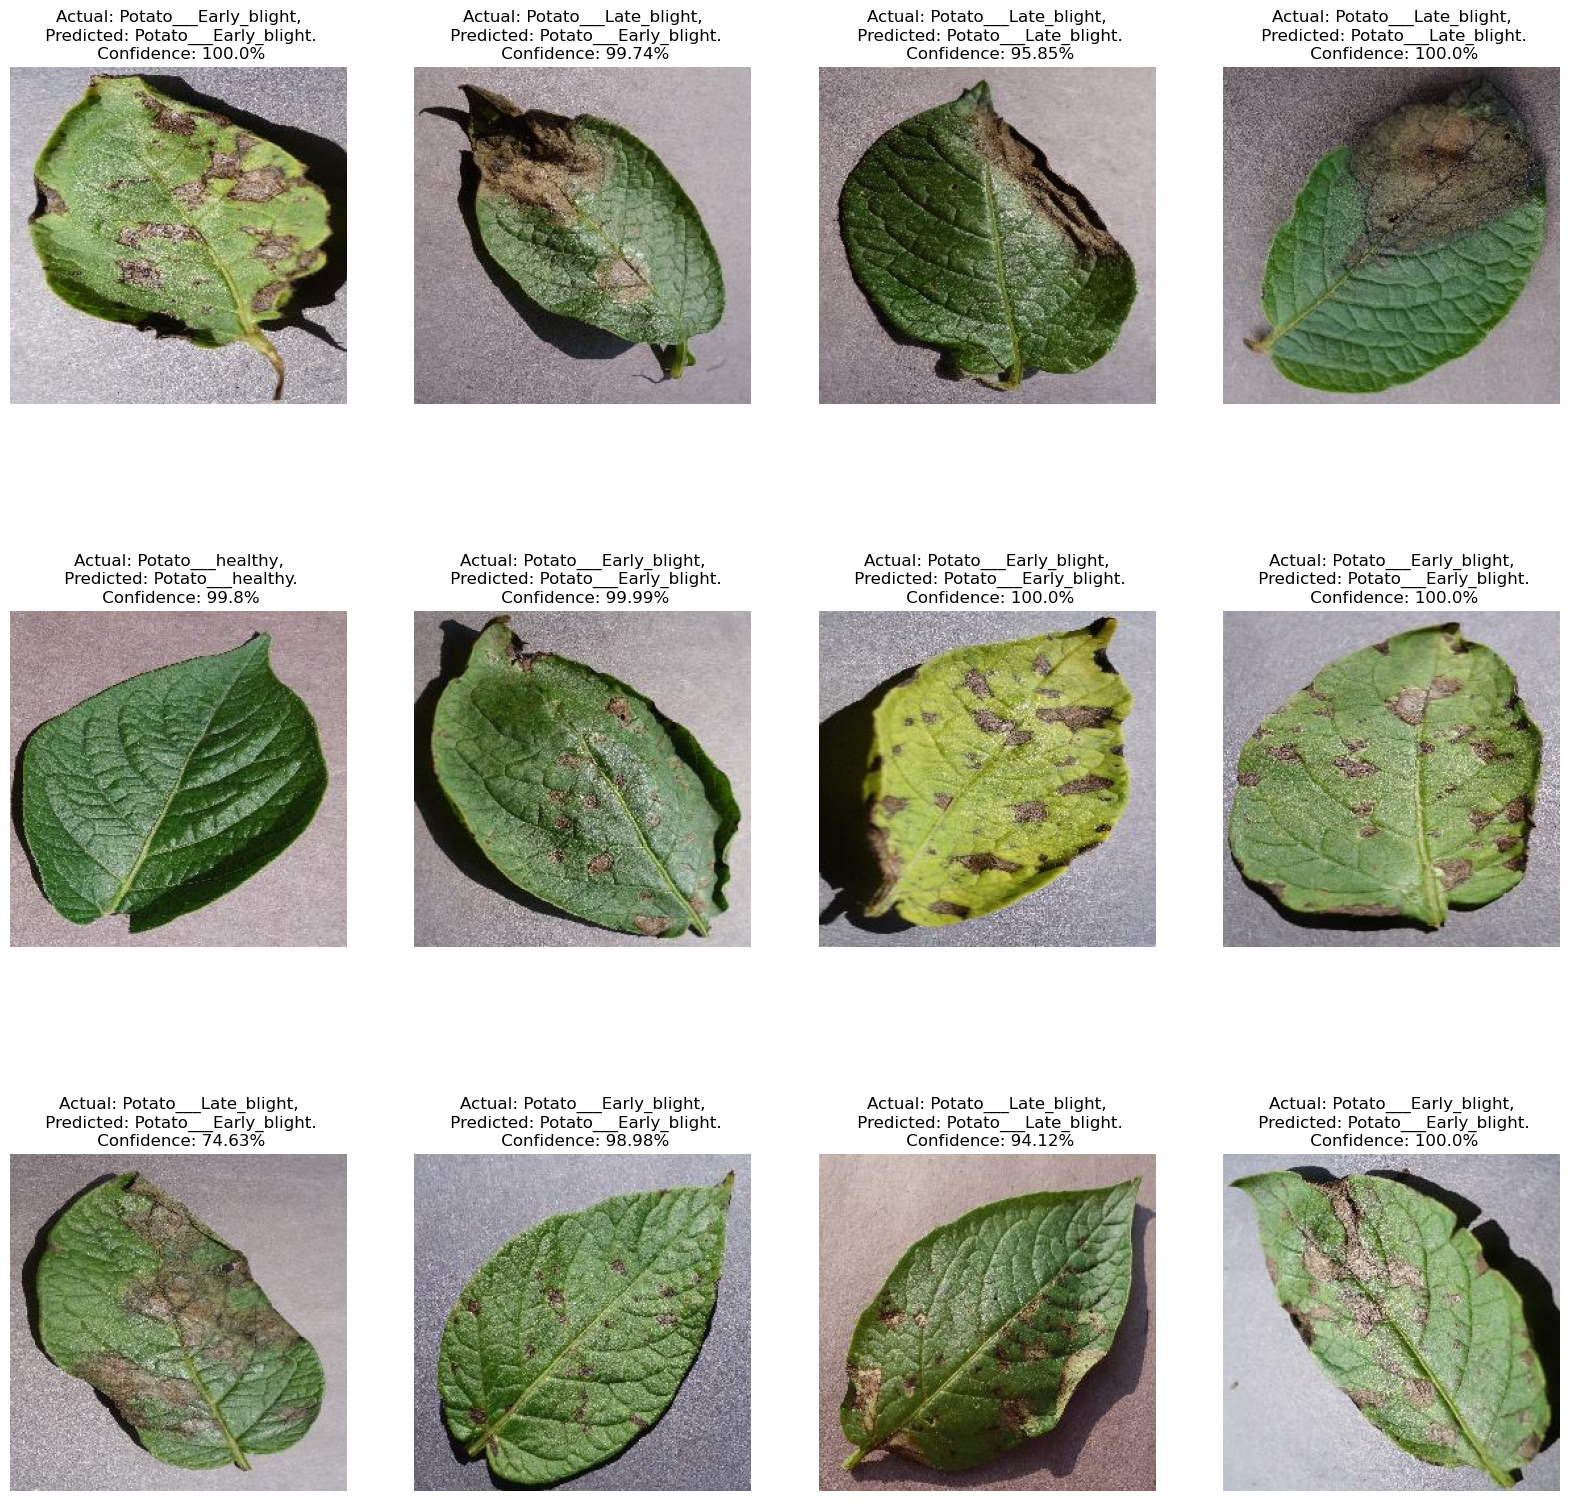

In [144]:
plt.figure(figsize = (20,20))
for image_batch, label_batch in dataset.take(1):
    
    for i in range (0,12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, image_batch[i].numpy())
        actual_class = class_names[label_batch[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis('off')

### Saving the model

In [146]:
import os
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [147]:
# for future version saving
import os
model_version = max([int(i) for i in os.listdir("../models")]) + 1
model_version

2